In [1]:
# Useful starting lines
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
%load_ext autoreload
%autoreload 2

# Load the training data into feature matrix, class labels, and event ids:

In [2]:
from proj1_helpers import *
DATA_TRAIN_PATH = '../data/train.csv'
y, tX, ids = load_csv_data(DATA_TRAIN_PATH)

### Simple data description 
- all variables are floating point, except PRI_jet_num which is integer
- variables prefixed with PRI (for PRImitives) are “raw” quantities about the bunch collision as measured by the detector.
- variables prefixed with DER (for DERived) are quantities computed from the primitive features, which were selected by the physicists of ATLAS.
- it can happen that for some entries some variables are meaningless or cannot be computed; in this case, their value is −999.0, which is outside the normal range of all variables.

In [3]:
print('y shape = ' + str(y.shape) + '\ntX shape =' + str(tX.shape) + '\nids shape = ' + str(ids.shape))

y shape = (250000,)
tX shape =(250000, 30)
ids shape = (250000,)


Description of the data:
- `y` (N) is composed of the labels (-1 or 1) of all the samples.  
- `tX` (N x F) is composed of the values of the features (F) for all samples (N)  
- `ids` (N) is composed of all the index (100000-349999) of the samples (N)  
  
Moreover, the number of features is 30 (F=30) and the number of samples is 250'000 (N=250'000). Non recorded data has value `-999`. 

In [4]:
from implementations import *

# Exploratory analysis

Feature 2:


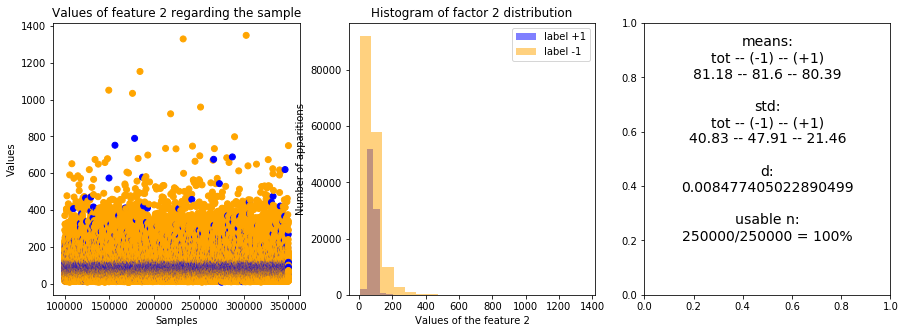

Feature 6:


/usr/local/anaconda3/lib/python3.7/site-packages/numpy/lib/histograms.py:829: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
/usr/local/anaconda3/lib/python3.7/site-packages/numpy/lib/histograms.py:830: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


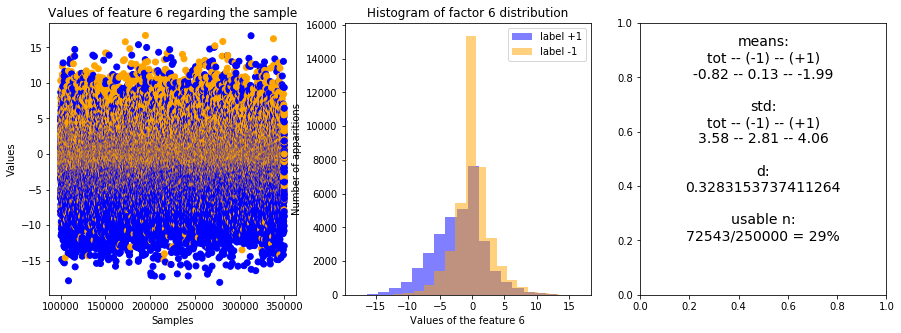

Feature 10:


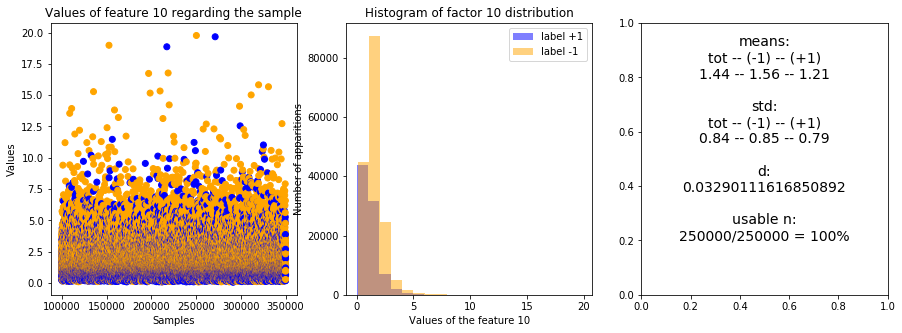

Feature 15:


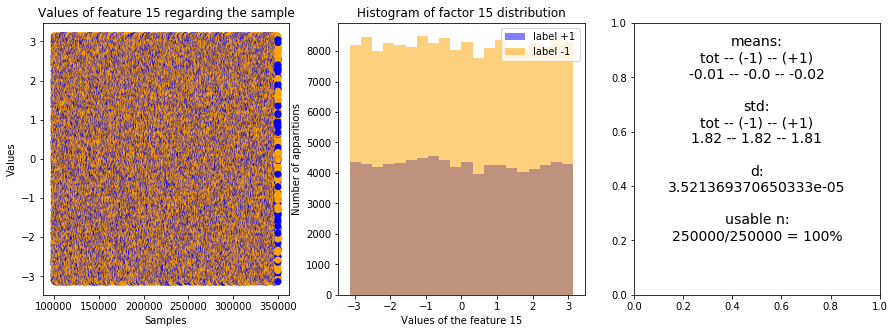

Feature 20:


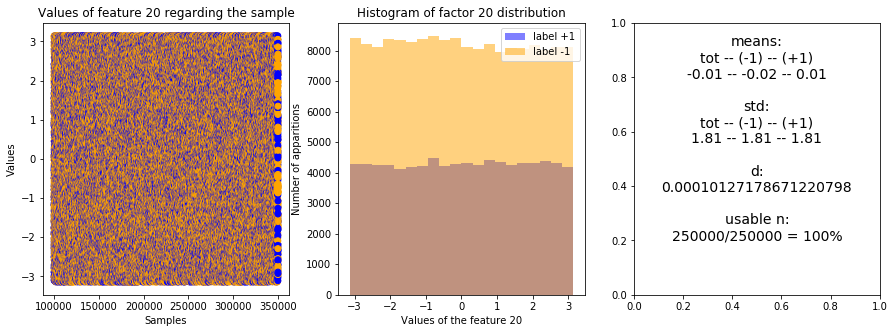

Feature 27:


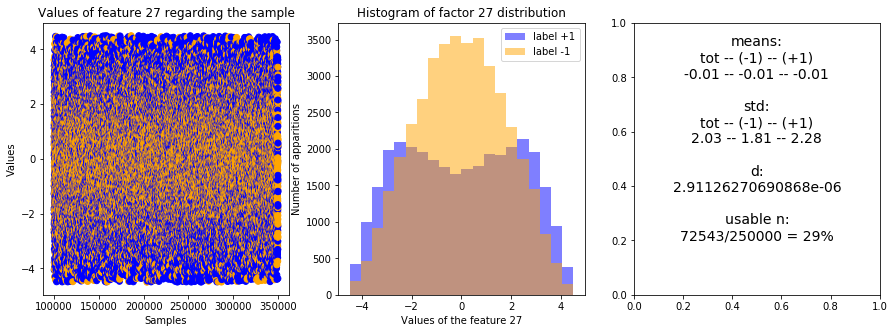

In [5]:
tX0 = np.where(tX==-999, np.nan,tX)

for f in [2, 6, 10, 15, 20, 27]:
    plot_feature(ids, tX0, y, f)

# Data pre-processing 

So for the data pre-processing, the first step is to remove the visible outliers in the Exploratory Analysis plots. 

In [6]:
# remove outliers based on the plots in the Exploratory analysis
y, tX = remove_outliers(y, tX, [0, 2, 3, 8, 13, 16, 19, 21, 23, 26],
                       [1100, 1000, 1000, 2500, 500, 500, 800, 1800, 800, 600])

# Feature processing

Then with this data, we separate the data points based on the categorical data: jet. We keep three matrices with `jet = 0`, `jet = 1` and `jet > 2`. We will futher train separately our models on each of these sub-matrices and have separated, learning rates, penalities or polynomial degrees for each. 

We still keep the whole data matrix to do the same treatments and generate whole weight matrices as a comparison. 

In [7]:
indices = np.random.choice(tX.shape[0], 1500, replace=False)

In [8]:
y = y[indices,]
tX = tX[indices,:]

In [9]:
idx0, y_jet0, tX_jet0, idx1, y_jet1, tX_jet1, idx2, y_jet2, tX_jet2 = separate_jet(y, tX)

For each dataset, we clean them by setting all missing values `-999` to `NaN`, then when for a feature the ratio of missing values reaches a threshold, we remove the whole feature from the dataset. The remaining missing data are replaced by the median value in the column (we also tried to replace the missing data by the mean value of the feature or a gaussian distribution. Then we standarize the data. 

In [10]:
missingness_cutoff = 0.5

In [11]:
tX, rmX = missingness_filter(tX, missingness_cutoff)

In [12]:
tX, mtX = impute_median_train(tX)

In [13]:
tX_jet0, rmX_jet0 = missingness_filter(tX_jet0, missingness_cutoff)
tX_jet1, rmX_jet1 = missingness_filter(tX_jet1, missingness_cutoff)
tX_jet2, rmX_jet2 = missingness_filter(tX_jet2, missingness_cutoff)
tX_jet0, median_jet0 = impute_median_train(tX_jet0)
tX_jet1, median_jet1 = impute_median_train(tX_jet1)
tX_jet2, median_jet2 = impute_median_train(tX_jet2)

In [14]:
print("tX shape={tXs}\ntX_jet0 shape={tX0s}\ntX_jet1 shape={tX1s}\ntX_jet2+ shape={tX2s}".format(
    tXs=tX.shape, tX0s=tX_jet0.shape, tX1s=tX_jet1.shape, tX2s=tX_jet2.shape))

print("\nremoved columns for :\ntX={rmX}\ntX_jet0={rmX0}\ntX_jet1={rmX1}\ntX_jet2+={rmX2}".format(
    rmX=rmX, rmX0=rmX_jet0, rmX1=rmX_jet1, rmX2=rmX_jet2))

tX shape=(1500, 23)
tX_jet0 shape=(604, 19)
tX_jet1 shape=(433, 22)
tX_jet2+ shape=(463, 29)

removed columns for :
tX=[ 4  5  6 12 26 27 28]
tX_jet0=[ 4  5  6 12 22 23 24 25 26 27]
tX_jet1=[ 4  5  6 12 25 26 27]
tX_jet2+=[]


## Least squares

### Full dataset

In [15]:
tX1,_,_ = standardize_train(tX.copy())

In [16]:
(w_ls, loss_ls) = least_squares(y, tX1)

print("w* ={w}\n\nmse={loss}".format(w=w_ls, loss=loss_ls))

w* =[ 4.65471530e-02 -2.10120708e-01 -2.95200948e-01  5.48051947e-02
  3.22091437e-01 -7.25364691e-02 -7.48350468e+03 -2.05432368e-01
  1.03966339e-01  1.43905404e+03 -1.25708213e-02  3.64531882e-02
  1.45388890e+03 -3.05612030e-02  7.55198549e-03  4.18671362e-02
 -2.01506141e-02 -6.79383382e-03  1.46687173e-01  3.35032105e-02
  3.55515924e-02 -1.63186581e-02  6.30876217e+03]

mse=0.4036518840697829


### Jet sub-datasets

In [17]:
for index_jet, (yi, txi) in enumerate(zip([y_jet0, y_jet1, y_jet2], [tX_jet0, tX_jet1, tX_jet2])):
    tx1, _, _ = standardize_train(txi.copy())
    (w_ls, loss_ls) = least_squares(yi, tx1)
    print("w_jet{jet}* = {w}\nmse = {loss}\n\n".format(
    jet=index_jet, w=w_ls, loss=loss_ls))

LinAlgError: Singular matrix

## Least squares with Gradient Descent

### Full dataset

In [19]:
#define parameters
initial_w = np.zeros(tX.shape[1])
max_iters = 100
gammas = np.logspace(-6, 0, 20)

losses_gd = np.empty(len(gammas))
ws_gd = np.empty((len(gammas), len(initial_w)))

tX1,_,_ = standardize_train(tX)

for idx, gamma in enumerate(gammas):
    (w, loss) = least_squares_GD(y, tX1, initial_w, max_iters, gamma)
    losses_gd[idx] = loss
    ws_gd[idx, :]=w

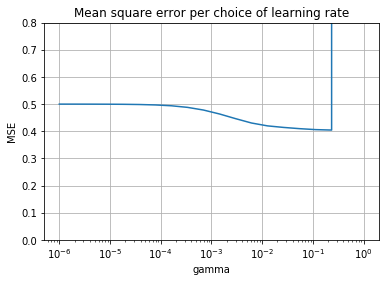

In [20]:
#plot the losses per gamma
fig, ax = plt.subplots()
ax.semilogx(gammas, losses_gd)

ax.set(xlabel='gamma', ylabel='MSE',
       title='Mean square error per choice of learning rate')
ax.grid()
ax.set_ylim([0, 0.8])
plt.show()

In [21]:
idx = np.nanargmin(losses_gd)

w_gd = ws_gd[idx]
gamma_gd = gammas[idx]

print("w* ={w}\n\nmse={loss}\n\ngamma={gamma}".format(
    w=w_gd, loss=losses_gd[idx], gamma=gamma_gd))

w* =[ 0.02957709 -0.21248961 -0.2525384   0.05528636  0.29921309 -0.07875186
  0.02605753 -0.18163302  0.10807108  0.15635896 -0.01221939  0.03687303
  0.24882096 -0.02891231  0.00632733  0.04286276 -0.01974555 -0.00973162
  0.10056649 -0.00084855  0.03443452 -0.01601648 -0.06207831]

mse=0.40450957053370085

gamma=0.23357214690901212


### Jet sub-datasets

In [22]:
#define parameters
max_iters = 100
gammas = np.logspace(-6, 0, 10)

for index_jet, (yi, txi) in enumerate(zip([y_jet0, y_jet1, y_jet2], [tX_jet0.copy(), tX_jet1.copy(), tX_jet2.copy()])):
    tx1, _, _ = standardize_train(txi.copy())
    initial_w = np.zeros(tx1.shape[1])
    losses_gd = np.empty(len(gammas))
    ws_gd = np.empty((len(gammas), len(initial_w)))

    for index_g, gamma in enumerate(gammas):
        (w, loss) = least_squares_GD(yi, tx1, initial_w, max_iters, gamma)
        losses_gd[index_g] = loss
        ws_gd[index_g, :]=w
        
    idx = np.nanargmin(losses_gd)
    w_gd = ws_gd[idx]
    gamma_gd = gammas[idx]
    print("w_jet{jet}* = {w}\nmse = {loss}\ngamma = {gamma}".format(
    jet=index_jet, w=w_gd, loss=losses_gd[idx], gamma=gamma_gd))

w_jet0* = [-0.00956429 -0.29964276 -0.40574106 -0.03050916  0.41933342 -0.03050986
  0.1246012  -0.0102398  -0.01794845  0.1501908  -0.06759977  0.04153523
  0.04211703  0.01078669  0.00527558  0.08613697 -0.0533454   0.06248015
  0.        ]
mse = 0.3838900677721064
gamma = 0.21544346900318823
w_jet1* = [ 0.02805947 -0.18659602 -0.25817506  0.04469558  0.19083896  0.0235908
  0.10773837 -0.13561878  0.19998746  0.16721784  0.04208843  0.05819585
  0.26056504 -0.1133308   0.00714511 -0.01780926  0.02691272 -0.06505841
 -0.03432217  0.05963555  0.03271897 -0.03432269]
mse = 0.39351667734407
gamma = 0.21544346900318823
w_jet2* = [-0.05345596 -0.12258426 -0.01645642  0.17063575  0.03920002  0.15005057
 -0.02654044  0.22157312 -0.0286753  -0.08074125 -0.23274781  0.05909973
  0.14998684  0.11818982 -0.03077759 -0.02058423  0.20051748 -0.03685078
 -0.00316223  0.09614056 -0.00456771  0.0229406  -0.03496142  0.0632703
 -0.06804313  0.09895396  0.08132801 -0.05667487 -0.19730967]
mse = 0.3887

## Least squares with Stochastic Gradient Descent

### Full dataset

In [23]:
initial_w = np.zeros(tX.shape[1])
max_iters = 100
gammas = np.logspace(-6, 0, 20)

losses_sgd = np.empty(len(gammas))
ws_sgd = np.empty((len(gammas), len(initial_w)))

tX1, _, _ = standardize_train(tX.copy())

for idx, gamma in enumerate(gammas):
    (w, loss) = least_squares_SGD(y, tX1, initial_w, max_iters, gamma)
    losses_sgd[idx] = loss
    ws_sgd[idx,:] = w

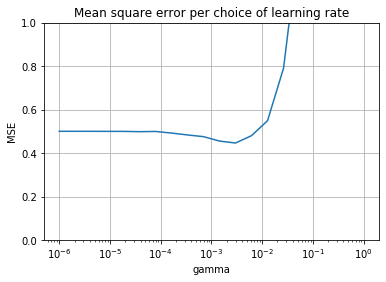

In [24]:
#plot the losses per gamma used
fig, ax = plt.subplots()
ax.semilogx(gammas, losses_sgd)

ax.set(xlabel='gamma', ylabel='MSE',
       title='Mean square error per choice of learning rate')
ax.grid()
ax.set_ylim([0, 1])
plt.show()

In [25]:
idx = np.nanargmin(losses_sgd)

w_sgd = ws_sgd[idx]
gamma_sgd = gammas[idx]

print("w*={w}\n\nmse={loss}\n\ngamma={gamma}".format(
    w=w_sgd, loss=losses_sgd[idx], gamma=gamma_sgd ))

w*=[-0.01516277 -0.12796244  0.00499214  0.03986562  0.0055523  -0.01718059
  0.05211249 -0.04230663  0.03728868  0.05062876  0.00327571  0.02420124
 -0.00835394 -0.01123064  0.01354287 -0.04417603  0.01490613  0.04123633
  0.04547234  0.04313874 -0.02103164  0.02182561  0.05219283]

mse=0.4459504188356198

gamma=0.002976351441631316


### Jet sub-datasets

In [26]:
#define parameters
max_iters = 100
gammas = np.logspace(-6, 0, 10)

for index_jet, (yi, txi) in enumerate(zip([y_jet0, y_jet1, y_jet2], [tX_jet0, tX_jet1, tX_jet2])):
    tx1, _, _ = standardize_train(txi.copy())
    initial_w = np.zeros(tx1.shape[1])
    losses_gd = np.empty(len(gammas))
    ws_gd = np.empty((len(gammas), len(initial_w)))

    for index_g, gamma in enumerate(gammas):
        (w, loss) = least_squares_SGD(yi, tx1, initial_w, max_iters, gamma)
        losses_gd[index_g] = loss
        ws_gd[index_g, :]=w
        
    idx = np.nanargmin(losses_gd)
    w_gd = ws_gd[idx]
    gamma_gd = gammas[idx]
    print("w_jet{jet}* = {w}\nmse = {loss}\ngamma = {gamma}".format(
    jet=index_jet, w=w_gd, loss=losses_gd[idx], gamma=gamma_gd))

w_jet0* = [ 0.02708276 -0.08280699  0.01024078 -0.00190857  0.04700285 -0.00190858
  0.051334   -0.04636306  0.01243461  0.07482878 -0.03152407 -0.02438407
  0.00515373 -0.01958086  0.00603096 -0.06455549 -0.00309387  0.0114164
  0.        ]
mse = 0.43697895288875604
gamma = 0.002154434690031882
w_jet1* = [ 0.0360014  -0.04396799  0.02847865  0.04616488 -0.01294887 -0.01558698
  0.06088453  0.00123498  0.06385009  0.05350514 -0.02862956  0.03603597
  0.05260857 -0.02030299  0.00789597  0.00227156  0.0147778   0.04305195
  0.04157784  0.00875505  0.00097487  0.04157781]
mse = 0.4579519555553059
gamma = 0.002154434690031882
w_jet2* = [-0.01884816 -0.07894062 -0.03207243  0.07523321  0.17040463  0.08303461
 -0.09832161 -0.0248835  -0.07914233 -0.04814288 -0.0107271   0.04335899
  0.05960502  0.05792552 -0.08858666  0.10035139  0.06932181 -0.08147301
 -0.01309437  0.0166173   0.04843616 -0.01206852 -0.03394447  0.02189235
 -0.08259637 -0.00198251  0.10288432 -0.01092266 -0.09832367]
mse = 

## Ridge regression

For ridge regression, we have two parameters to optimize, the lambda (penality) and degree (complexity). To do so, we use a cross validation that optimizes both at the same time. 

Then a biais and variance decomposition is used to visualize if the methods tend to underfit or overfit. 

### Full dataset

#### Cross-validation hyperparameter selection

In [27]:
w_interaction = False

In [28]:
seed = 1
degree_ri = 1
k_fold = 4
lambdas = np.logspace(-20, -8, 13)
degrees = range(1, 15)

k_indices = build_k_indices(y, k_fold, seed)

rmse_tr_ri, rmse_te_ri, acc_measures = cross_validation_wAcc(y, tX, k_indices, k_fold, degrees, 
                                          lambdas , ml_function = 'ri', max_iters = 100, 
                                          gamma = 0.05, verbose = True, interaction=w_interaction)

Finished preparing data for cross-validation 

Completed degree 14/14
 Completed lambda 1/13
Completed degree 14/14
 Completed lambda 2/13
Completed degree 14/14
 Completed lambda 3/13
Completed degree 14/14
 Completed lambda 4/13
Completed degree 14/14
 Completed lambda 5/13
Completed degree 14/14
 Completed lambda 6/13
Completed degree 14/14
 Completed lambda 7/13
Completed degree 14/14
 Completed lambda 8/13
Completed degree 14/14
 Completed lambda 9/13
Completed degree 14/14
 Completed lambda 10/13
Completed degree 14/14
 Completed lambda 11/13
Completed degree 14/14
 Completed lambda 12/13
Completed degree 14/14
 Completed lambda 13/13


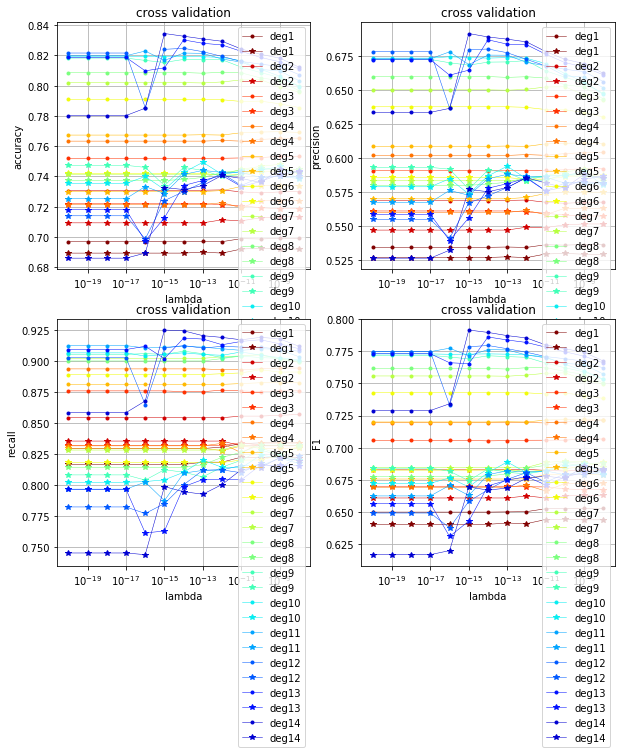

In [29]:
vis_cv_acc(degrees,lambdas,acc_measures)

In [30]:
idx = np.unravel_index(np.nanargmax(acc_measures["acc_te"]), acc_measures["acc_te"].shape)
lambda_ri = lambdas[idx[0]]
degree_ri = degrees[idx[1]]

print("lambda*={lambda_}\n\ndegree*={degree}\n\nrmse train={rmse_tr}\n\nrmse test={rmse_te}\n\nacc train={acc_tr}\n\nacc test={acc_te}".format(
    lambda_=lambda_ri, degree=degree_ri, rmse_tr=rmse_tr_ri[idx], rmse_te=rmse_te_ri[idx],acc_tr=acc_measures["acc_tr"][idx], acc_te=acc_measures["acc_te"][idx]))

lambda*=1e-13

degree*=10

rmse train=0.2734929290154934

rmse test=8614308.770037739

acc train=0.819111111111111

acc test=0.7493333333333333


In [31]:
w_ri, loss_ri, acc_measures_ri, data_meas_ri = build_final_model(y, tX, degree_ri,
                                                      lambda_ri, ml_function = 'ri', interaction = w_interaction)

In [32]:
data_meas_ri["mean"].shape

(231,)

In [33]:
print(acc_measures_ri)

{'acc': 0.804, 'pre': 0.656934306569343, 'rec': 0.8840864440078585, 'f1': 0.7537688442211056}


#### Bias-variance decomposition for complexity determination

In [34]:
ratio_train = 0.1
seeds = range(50)

In [35]:
rmse_tr_bv = np.empty((len(seeds), len(degrees)))
rmse_te_bv = np.empty((len(seeds), len(degrees)))

for index_seed, seed in enumerate(seeds):
    np.random.seed(seed)
    x_tr, x_te, y_tr, y_te = split_data(tX.copy(), y, ratio_train, seed) 
    
    x_tr, x_te = standardize_both(x_tr, x_te)
    
    for index_deg, deg in enumerate(degrees): 
        tx_tr = build_poly(x_tr, deg)
        tx_te = build_poly(x_te, deg)
            
        w_tr, mse_tr = ridge_regression(y_tr, tx_tr, lambda_ri)
        mse_te = compute_mse(y_te, tx_te, w_tr)
            
        rmse_tr_bv[index_seed][index_deg] = np.sqrt(2*mse_tr)
        rmse_te_bv[index_seed][index_deg] = np.sqrt(2*mse_te)

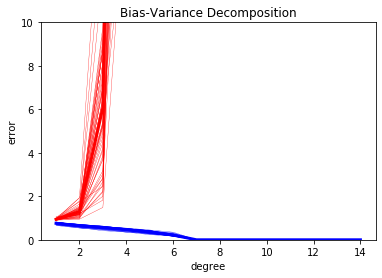

In [36]:
bias_variance_decomposition_visualization(degrees, rmse_tr_bv, rmse_te_bv)

Based on the plot above, change the value of `degree_ri` manually. 

### Jet sub-datasets

#### Cross-validation for hyperparameter selection

Finished preparing data for cross-validation 

Completed degree 4/4
 Completed lambda 1/5
Completed degree 4/4
 Completed lambda 2/5
Completed degree 4/4
 Completed lambda 3/5
Completed degree 4/4
 Completed lambda 4/5
Completed degree 4/4
 Completed lambda 5/5
lambda*=0.0001

degree*=3

rmse train=0.3415877411830682

rmse test=0.3999329127893255

acc train=0.7610375275938189

acc test=0.7317880794701986
{'acc': 0.7649006622516556, 'pre': 0.5037593984962406, 'rec': 0.9305555555555556, 'f1': 0.6536585365853659}


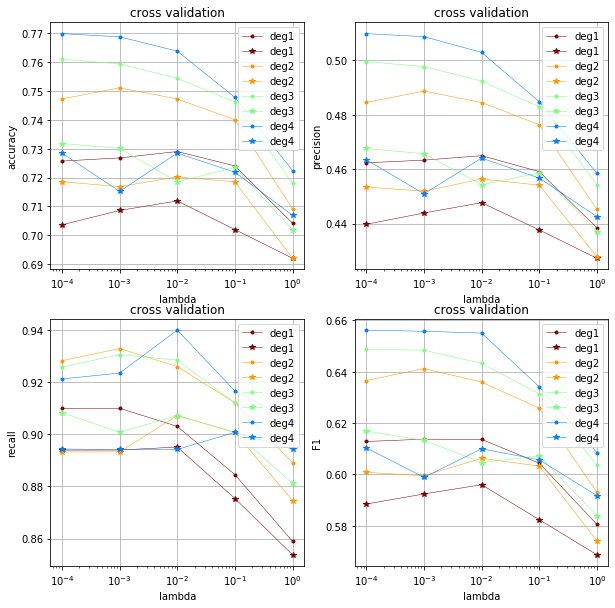

In [37]:
seed = 1
k_fold = 4
lambdas = np.logspace(-4, 0, 5)
degrees = range(1, 5)

k_indices = build_k_indices(y_jet0, k_fold, seed)

rmse_tr_ri, rmse_te_ri, acc_measures = cross_validation_wAcc(y_jet0, tX_jet0, k_indices, k_fold, degrees, 
                                          lambdas , ml_function = 'ri', max_iters = 100, 
                                          gamma = 0.05, verbose = True, interaction=w_interaction)

idx = np.unravel_index(np.nanargmax(acc_measures["acc_te"]), acc_measures["acc_te"].shape)
lambda_ri_jet0 = lambdas[idx[0]]
degree_ri_jet0 = degrees[idx[1]]

print("lambda*={lambda_}\n\ndegree*={degree}\n\nrmse train={rmse_tr}\n\nrmse test={rmse_te}\n\nacc train={acc_tr}\n\nacc test={acc_te}".format(
    lambda_=lambda_ri_jet0, degree=degree_ri_jet0, rmse_tr=rmse_tr_ri[idx], rmse_te=rmse_te_ri[idx],acc_tr=acc_measures["acc_tr"][idx], acc_te=acc_measures["acc_te"][idx]))

vis_cv_acc(degrees,lambdas,acc_measures)

w0_ri, loss0_ri, acc_measures0_ri, data_meas0_ri = build_final_model(y_jet0, tX_jet0, degree_ri_jet0,
                                                      lambda_ri_jet0, ml_function = 'ri', interaction = w_interaction)

print(acc_measures0_ri)

Finished preparing data for cross-validation 

Completed degree 4/4
 Completed lambda 1/5
Completed degree 4/4
 Completed lambda 2/5
Completed degree 4/4
 Completed lambda 3/5
Completed degree 4/4
 Completed lambda 4/5
Completed degree 4/4
 Completed lambda 5/5
lambda*=0.01

degree*=3

rmse train=0.31820934323669436

rmse test=0.39382207351661674

acc train=0.7700617283950617

acc test=0.7199074074074074
{'acc': 0.7551963048498845, 'pre': 0.6027397260273972, 'rec': 0.8741721854304636, 'f1': 0.7135135135135136}


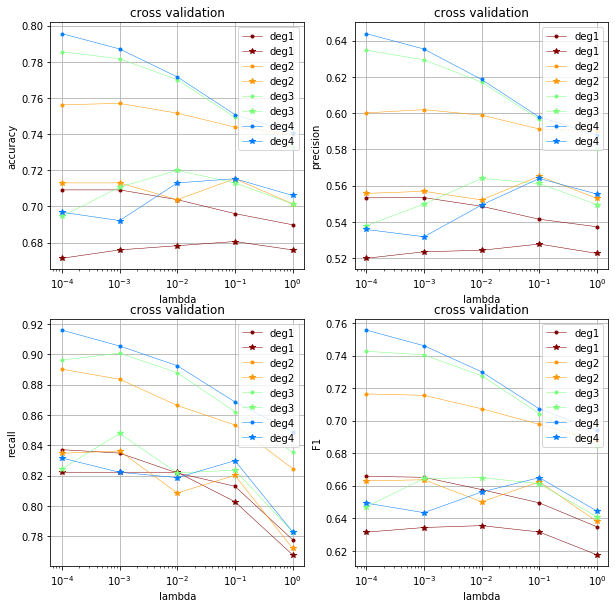

In [38]:
k_indices = build_k_indices(y_jet1, k_fold, seed)

rmse_tr_ri, rmse_te_ri, acc_measures = cross_validation_wAcc(y_jet1, tX_jet1, k_indices, k_fold, degrees, 
                                          lambdas , ml_function = 'ri', max_iters = 100, 
                                          gamma = 0.05, verbose = True, interaction=w_interaction)

idx = np.unravel_index(np.nanargmax(acc_measures["acc_te"]), acc_measures["acc_te"].shape)
lambda_ri_jet1 = lambdas[idx[0]]
degree_ri_jet1 = degrees[idx[1]]

print("lambda*={lambda_}\n\ndegree*={degree}\n\nrmse train={rmse_tr}\n\nrmse test={rmse_te}\n\nacc train={acc_tr}\n\nacc test={acc_te}".format(
    lambda_=lambda_ri_jet1, degree=degree_ri_jet1, rmse_tr=rmse_tr_ri[idx], rmse_te=rmse_te_ri[idx],acc_tr=acc_measures["acc_tr"][idx], acc_te=acc_measures["acc_te"][idx]))

vis_cv_acc(degrees,lambdas,acc_measures)

w1_ri, loss1_ri, acc_measures1_ri, data_meas1_ri = build_final_model(y_jet1, tX_jet1, degree_ri_jet1,
                                                      lambda_ri_jet1, ml_function = 'ri', interaction = w_interaction)

print(acc_measures1_ri)

Finished preparing data for cross-validation 

Completed degree 4/4
 Completed lambda 1/5
Completed degree 4/4
 Completed lambda 2/5
Completed degree 4/4
 Completed lambda 3/5
Completed degree 4/4
 Completed lambda 4/5
Completed degree 4/4
 Completed lambda 5/5
lambda*=0.0001

degree*=2

rmse train=0.3276446343922228

rmse test=0.5482681715424078

acc train=0.7543478260869565

acc test=0.6717391304347826
{'acc': 0.7408207343412527, 'pre': 0.6926229508196722, 'rec': 0.7897196261682243, 'f1': 0.7379912663755458}


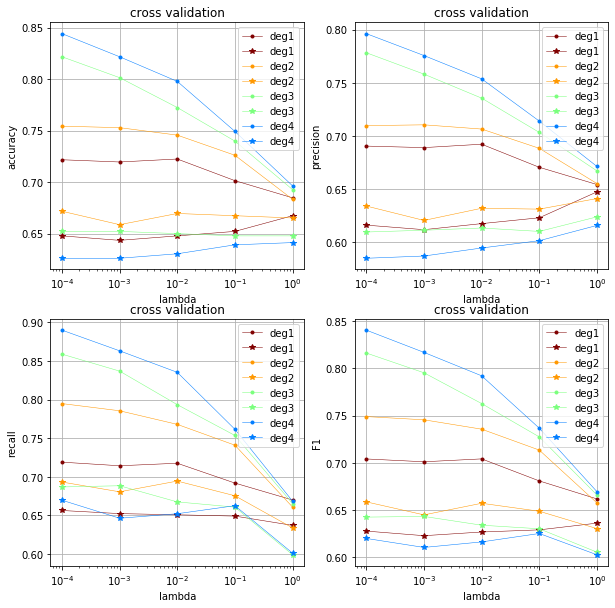

In [39]:
k_indices = build_k_indices(y_jet2, k_fold, seed)

rmse_tr_ri, rmse_te_ri, acc_measures = cross_validation_wAcc(y_jet2, tX_jet2, k_indices, k_fold, degrees, 
                                          lambdas , ml_function = 'ri', max_iters = 100, 
                                          gamma = 0.05, verbose = True, interaction=w_interaction)

idx = np.unravel_index(np.nanargmax(acc_measures["acc_te"]), acc_measures["acc_te"].shape)
lambda_ri_jet2 = lambdas[idx[0]]
degree_ri_jet2 = degrees[idx[1]]

print("lambda*={lambda_}\n\ndegree*={degree}\n\nrmse train={rmse_tr}\n\nrmse test={rmse_te}\n\nacc train={acc_tr}\n\nacc test={acc_te}".format(
    lambda_=lambda_ri_jet2, degree=degree_ri_jet2, rmse_tr=rmse_tr_ri[idx], rmse_te=rmse_te_ri[idx],acc_tr=acc_measures["acc_tr"][idx], acc_te=acc_measures["acc_te"][idx]))

vis_cv_acc(degrees,lambdas,acc_measures)

w2_ri, loss2_ri, acc_measures2_ri, data_meas2_ri = build_final_model(y_jet2, tX_jet2, degree_ri_jet2,
                                                      lambda_ri_jet2, ml_function = 'ri', interaction = w_interaction)

print(acc_measures2_ri)

## Logistic regression

### Full dataset

In [40]:
ltX = build_poly_inter(tX.copy(), 1, interaction = w_interaction)
ltX, _, _ = standardize_train(ltX)

In [41]:
yl = np.where(y==-1, 0, y)
max_iters = 1000
gammas = np.logspace(-10, -1, 20)
initial_w = np.zeros(ltX.shape[1])

In [42]:
losses_lr = np.empty(len(gammas))
ws_lr = np.empty((len(gammas), len(initial_w)))
for idx, gamma in enumerate(gammas):
    (w, loss) = logistic_regression(yl, ltX, initial_w, max_iters, gamma)
    losses_lr[idx] = loss
    ws_lr[idx, :] = w

/Users/Robin/Documents/EPFL/2019-2020/ML/Machine-learning-Project-2019/scripts/implementations.py:354: RuntimeWarning: divide by zero encountered in log
  return -y.T.dot(np.log(h))-(1-y).T.dot(np.log(1-h))
/Users/Robin/Documents/EPFL/2019-2020/ML/Machine-learning-Project-2019/scripts/implementations.py:340: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-t))


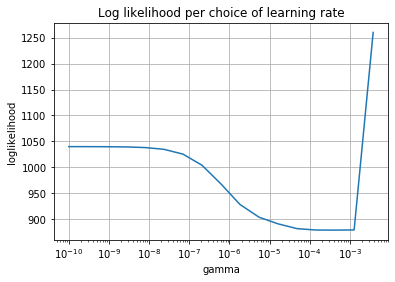

In [43]:
#plot the losses per gamma used
fig, ax = plt.subplots()
ax.semilogx(gammas, losses_lr)

ax.set(xlabel='gamma', ylabel='loglikelihood',
       title='Log likelihood per choice of learning rate')
ax.grid()
plt.show()

In [44]:
idx = np.nanargmin(losses_lr)

w_lr = ws_lr[idx]
gamma_lr = gammas[idx]

print("w* ={w}\n\nloglikelihood loss={loss}\n\ngamma={gamma}".format(
    w=w_lr, loss=losses_lr[idx], gamma = gamma_lr))

w* =[ 0.          0.15818093 -0.47574187 -0.85730401  0.29752842  0.866629
 -0.20715858  0.02202792 -0.56460151  0.18580579  0.39255391 -0.03574169
  0.10182473  0.76854452 -0.073755    0.01204553  0.02509584 -0.05726449
 -0.0095294   0.29948686  0.07808933  0.07673801 -0.04777244 -0.2404225 ]

loglikelihood loss=878.4010732906132

gamma=0.0004281332398719387


#### Cross-validation for hyperparameter determination

In [45]:
seed = 1
k_fold = 4
degrees = range(1, 9)

k_indices = build_k_indices(y, k_fold, seed)

loss_tr_lr, loss_te_lr, acc_measures_lr = cross_validation_wAcc(yl, tX, k_indices, k_fold, degrees, lambdas = [0],
                                                                 ml_function = 'lr', max_iters = 1000, gamma = gamma_lr,
                                                                 verbose = True, interaction = w_interaction)

Finished preparing data for cross-validation 

Completed degree 8/8
 Completed lambda 1/1


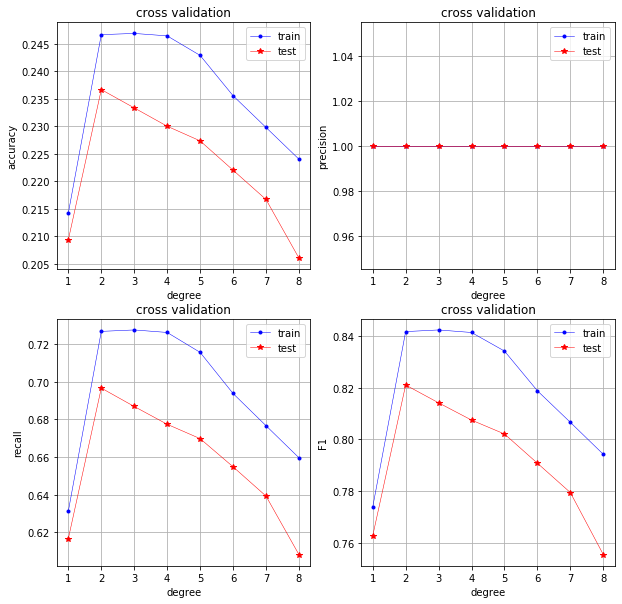

In [46]:
vis_cv_acc(degrees,lambdas,acc_measures_lr)

In [47]:
loss_te_lr = np.array(loss_te_lr)
loss_tr_lr = np.array(loss_tr_lr)

idx = np.nanargmax(acc_measures_lr["acc_te"])

degree_lr = degrees[idx]

print("degree*={degree}\n\nloglikelihood train={loss_tr}\n\nloglikelihood test={loss_te}\n\nacc train={acc_tr}\n\nacc test={acc_te}".format(
    degree=degree_lr, loss_tr=loss_tr_lr.flatten()[idx], loss_te=loss_te_lr.flatten()[idx],
    acc_tr=acc_measures_lr["acc_tr"].flatten()[idx], acc_te=acc_measures_lr["acc_te"].flatten()[idx]))

degree*=2

loglikelihood train=599.2168432167896

loglikelihood test=216.199844672305

acc train=0.24666666666666667

acc test=0.2366666666666667


## Regularized logistic regression

### Full dataset

In [48]:
ltX = build_poly_inter(tX.copy(), 1, interaction = w_interaction)
ltX, _, _ = standardize_train(ltX)

In [49]:
initial_w = np.zeros(ltX.shape[1])
max_iters = 1000
gammas = np.logspace(-10, -1, 20)
lambda_rlr = lambda_ri

In [50]:
losses_rlr = np.empty(len(gammas))
ws_rlr = np.empty((len(gammas), len(initial_w)))
for idx, gamma in enumerate(gammas):
    (w, loss) = reg_logistic_regression(yl, ltX, lambda_rlr, initial_w, max_iters, gamma)
    losses_rlr[idx] = loss
    ws_rlr[idx, :] = w

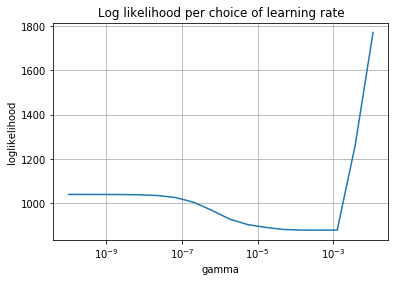

In [51]:
#plot the losses per gamma used
fig, ax = plt.subplots()
ax.semilogx(gammas, losses_rlr)

ax.set(xlabel='gamma', ylabel='loglikelihood',
       title='Log likelihood per choice of learning rate')
ax.grid()
plt.show()

In [52]:
idx = np.nanargmin(losses_rlr)

w_rlr = ws_rlr[idx]
gamma_rlr = gammas[idx]

print("w* ={w}\n\nloglikelihood loss={loss}\n\ngamma={gamma}".format(
    w=w_rlr, loss=losses_rlr[idx], gamma = gamma_rlr))

w* =[ 0.          0.15818093 -0.47574187 -0.85730401  0.29752842  0.866629
 -0.20715858  0.02202792 -0.56460151  0.18580579  0.39255391 -0.03574169
  0.10182473  0.76854452 -0.073755    0.01204553  0.02509584 -0.05726449
 -0.0095294   0.29948686  0.07808933  0.07673801 -0.04777244 -0.2404225 ]

loglikelihood loss=878.4010732906132

gamma=0.0004281332398719387


#### Cross-validation hyperparameter selection

In [53]:
seed = 1
degree_rlr = 1
k_fold = 4
lambdas = np.logspace(-8, -2, 5)
degrees = range(1, 5)

k_indices = build_k_indices(yl, k_fold, seed)

In [54]:
loss_tr_rlr, loss_te_rlr, acc_measures_rlr = cross_validation_wAcc(yl, tX, k_indices, k_fold, degrees,
                                                                   lambdas, ml_function = 'rlr', max_iters = 500,
                                                                   gamma = gamma_rlr, verbose = True,
                                                                   interaction = w_interaction)

Finished preparing data for cross-validation 

Completed degree 4/4
 Completed lambda 1/5
Completed degree 4/4
 Completed lambda 2/5
Completed degree 4/4
 Completed lambda 3/5
Completed degree 4/4
 Completed lambda 4/5
Completed degree 4/4
 Completed lambda 5/5


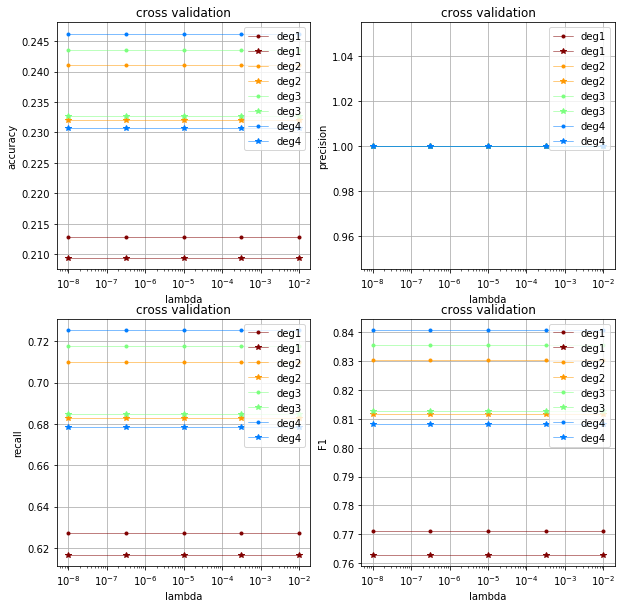

In [55]:
vis_cv_acc(degrees,lambdas, acc_measures_rlr)

In [56]:
idx = np.unravel_index(np.nanargmax(acc_measures_rlr["acc_te"]), acc_measures_rlr["acc_te"].shape)
lambda_rlr = lambdas[idx[0]]
degree_rlr = degrees[idx[1]]

print("degree*={degree}\n\nloglikelihood train={loss_tr}\n\nloglikelihood test={loss_te}\n\nacc train={acc_tr}\n\nacc test={acc_te}".format(
    degree=degree_rlr, loss_tr=loss_tr_rlr[idx], loss_te=loss_te_rlr[idx],
    acc_tr=acc_measures_rlr["acc_tr"][idx], acc_te=acc_measures_rlr["acc_te"][idx]))

degree*=3

loglikelihood train=594.2354473018413

loglikelihood test=223.0994607052325

acc train=0.24355555555555555

acc test=0.23266666666666666


#### Bias-variance decomposition for complexity determination

In [57]:
ratio_train = 0.1
seeds = range(50)
degrees = range(1, 9)
lambda_rlr = lambda_ri

In [58]:
loss_tr_bv = np.empty((len(seeds), len(degrees)))
loss_te_bv = np.empty((len(seeds), len(degrees)))

for index_seed, seed in enumerate(seeds):
    np.random.seed(seed)
        
    x_tr, x_te, y_tr, y_te = split_data(tX, y, ratio_train, seed)  
    
    x_tr, x_te = standardize_both(x_tr, x_te)

    for index_deg, deg in enumerate(degrees):
        tx_tr = build_poly(x_tr, deg)
        tx_te = build_poly(x_te, deg)
        
        initial_w = np.zeros(tx_tr.shape[1])
        
        w_tr, log_tr = reg_logistic_regression(y_tr, tx_tr, lambda_rlr, initial_w, max_iters, gamma_rlr)
        log_te = compute_loglikelihood(y_te, tx_te, w_tr)
            
        loss_tr_bv[index_seed][index_deg] = log_tr
        loss_tr_bv[index_seed][index_deg] = log_te

/Users/Robin/Documents/EPFL/2019-2020/ML/Machine-learning-Project-2019/scripts/implementations.py:354: RuntimeWarning: invalid value encountered in double_scalars
  return -y.T.dot(np.log(h))-(1-y).T.dot(np.log(1-h))


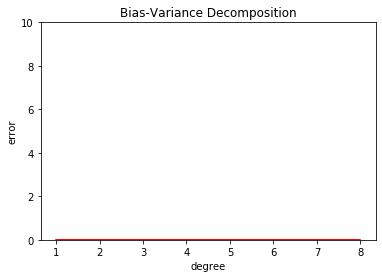

In [59]:
bias_variance_decomposition_visualization(degrees, loss_tr_bv, loss_te_bv)

Based on the plot above, change the value of `degree_rlr` manually. 

# Generate predictions and save ouput in csv format for submission:

In [ ]:
DATA_TEST_PATH = '../data/test.csv' 
_, tX_test, ids_test = load_csv_data(DATA_TEST_PATH)

In [ ]:
indices = np.random.choice(tX_test.shape[0], 1500, replace=False)

In [ ]:
tX_test = tX_test[indices,:]

##### Full dataset

In [ ]:
y_pred = make_prediction(tx=tX_test.copy(), weights = w_ri.copy(), rmx = rmX.copy(), median = mtX.copy(),
                          d=degree_ri, train_data_measures=data_meas_ri, 
                         interactions = w_interaction, ml_function = "ri")

In [ ]:
OUTPUT_PATH = '../data/submission.csv'
create_csv_submission(ids_test, y_pred, OUTPUT_PATH)

##### Jet sub-datasets

In [ ]:
y_test = np.zeros(tX_test.shape[0])
idx_test0, y_test0, tX_test0, idx_test1, y_test1, tX_test1, idx_test2, y_test2, tX_test2 = separate_jet(y_test, tX_test)

In [ ]:
y_test0 = make_prediction(tX_test0, w0_ri, rmX_jet0, median_jet0,
                          degree_ri_jet0, data_meas0_ri, interactions = w_interaction, ml_function = "ri")

In [ ]:
y_test1 = make_prediction(tX_test1, w1_ri, rmX_jet1, median_jet1,
                          degree_ri_jet1, data_meas1_ri, interactions = w_interaction, ml_function = "ri")

In [ ]:
y_test2 = make_prediction(tX_test2, w2_ri, rmX_jet2, median_jet2,
                          degree_ri_jet2, data_meas2_ri, interactions = w_interaction, ml_function = "ri")

In [ ]:
OUTPUT_PATH = '../data/submission.csv'
y_pred = merge_jet(idx_test0, y_test0, idx_test1, y_test1, idx_test2, y_test2)
create_csv_submission(ids_test, y_pred, OUTPUT_PATH)